In [4]:
%matplotlib inline 

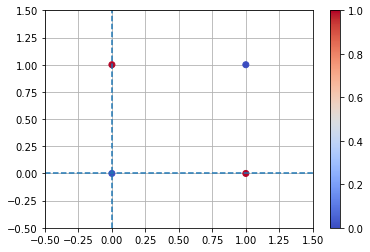

In [5]:
# visualize task
import matplotlib.pyplot as plt
plt.rc('axes', axisbelow=True)

xs   = [0, 1, 0, 1]
ys   = [0, 0, 1, 1]
xor  = [0, 1, 1, 0]

plt.scatter(xs, ys, c=xor, cmap='coolwarm')
plt.colorbar()

plt.xlim(-0.5, 1.5) 
plt.ylim(-0.5, 1.5)

plt.grid(True)

plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')

In [6]:
!pip install tensorboard

In [36]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [23]:
import numpy as np
from tensorboardX import SummaryWriter
from datetime import datetime
logdir = "logs"

In [24]:
def activation(x):
    return 1.0 / (1.0 + np.exp(-x))
def dactivation(x):
    return np.exp(-x) / (1 + np.exp(-x))**2

In [25]:
# MultiLayer Perceptron class
class MLP:
    def __init__(self, *args):
        np.random.seed(123)
        self.shape = args
        n = len(args)
        self.layers = []
        self.layers.append(np.ones(self.shape[0]+1))   # input layer
        for i in range(1,n):   # hidden layers
            self.layers.append(np.ones(self.shape[i]))
        self.weights = [] # weights for all layers
        for i in range(n-1):   
            self.weights.append(np.zeros((self.layers[i].size,
                                         self.layers[i+1].size)))
        self.reset()
    
    def reset(self):
        for i in range(len(self.weights)):
            Z = np.random.random((self.layers[i].size,self.layers[i+1].size))
            self.weights[i][...] = (2*Z-1)*1

    def propagate_forward(self, data):
        self.layers[0][0:-1] = data # set input
        for i in range(1,len(self.shape)):
            s_i = np.dot(self.layers[i-1], self.weights[i-1])
            self.layers[i][...] = activation(s_i)
        return self.layers[-1]

    def propagate_backward(self, target, lrate=0.1):
        deltas = []
        derror = -(target-self.layers[-1]) # y-y^
        s_last = np.dot(self.layers[-2],self.weights[-1])
        delta_last = derror * dactivation(s_last)
        deltas.append(delta_last)
        for i in range(len(self.shape)-2,0,-1):
            s_i = np.dot(self.layers[i-1],self.weights[i-1])
            delta_i = np.dot(deltas[0],self.weights[i].T)*dactivation(s_i)
            deltas.insert(0,delta_i)            
        for i in range(len(self.weights)):
            layer = np.atleast_2d(self.layers[i])
            delta = np.atleast_2d(deltas[i])
            dw = -lrate*np.dot(layer.T,delta)
            self.weights[i] += dw 

        error = (target-self.layers[-1])**2 
        return error.sum()

In [26]:
from sklearn import preprocessing
def learn(network, X, Y, valid_split, test_split, writer, epochs=20, lrate=0.1):
    # Prepocessing
        nb_samples = len(Y)
        X_train = X[0:int(nb_samples*(1-valid_split-test_split))]
        Y_train = Y[0:int(nb_samples*(1-valid_split-test_split))]
        X_valid = X[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        Y_valid = Y[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        X_test  = X[int(nb_samples*(1-test_split)):]
        Y_test  = Y[int(nb_samples*(1-test_split)):]
    
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test  = scaler.transform(X_test)
    
        randperm = np.random.permutation(len(X_train))
        X_train, Y_train = X_train[randperm], Y_train[randperm]
        
    # Train (SGD/Stochastic Gradient Descent)   
        for i in range(epochs):
            train_err = 0
            for k in range(X_train.shape[0]):
                network.propagate_forward( X_train[k] )
                train_err += network.propagate_backward( Y_train[k], lrate )
            train_err /= X_train.shape[0]

    # Validation
            valid_err = 0
            o_valid = np.zeros(X_valid.shape[0])
            for k in range(X_valid.shape[0]):
                o_valid[k] = network.propagate_forward(X_valid[k])
                valid_err += (o_valid[k]-Y_valid[k])**2
            valid_err /= X_valid.shape[0]
            
            
            writer.add_scalar('train', scalar_value=train_err, global_step=i)
            writer.add_scalar('validation', scalar_value=valid_err, global_step=i)
            print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i, train_err, valid_err))

    # Testing
        print("\n--- TESTING ---\n")
        test_err = 0
        o_test = np.zeros(X_test.shape[0])
        for k in range(X_test.shape[0]):
            o_test[k] = network.propagate_forward(X_test[k])
            test_err += (o_test[k]-Y_test[k])**2
            print(k, X_test[k], '%.2f' % o_test[k], ' (expected value: %.2f)' % Y_test[k])
        test_err /= X_test.shape[0]

        plt.scatter(X_test[:,0], X_test[:,1], c=np.round(o_test[:]), cmap=plt.cm.coolwarm)

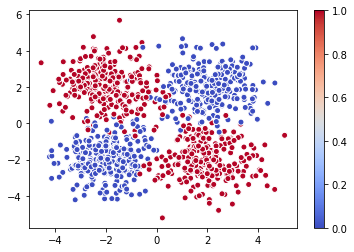

In [27]:
# Generating data:
nb_samples=1024
X = np.zeros((nb_samples,2))
Y = np.zeros(nb_samples)
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    X[i], Y[i] = (-2+noise[0],-2+noise[1]), 0
    X[i+1], Y[i+1] = (2+noise[2],-2+noise[3]), 1
    X[i+2], Y[i+2] = (-2+noise[4],2+noise[5]), 1
    X[i+3], Y[i+3] = (2+noise[6],2+noise[7]), 0

plt.scatter(X[:,0],X[:,1],c=Y[:], cmap=plt.cm.coolwarm, linewidth=1, edgecolors='w')
plt.colorbar();

In [28]:
network = MLP(2,100,10,1)

In [29]:
now = datetime.now()
date_time = now.strftime("%Y%m%d_%H-%M-%S")
writer = SummaryWriter(logdir+"/"+date_time, flush_secs=1)

0 epoch, train_err: 0.1331, valid_err: 0.0388
1 epoch, train_err: 0.0588, valid_err: 0.0355
2 epoch, train_err: 0.0505, valid_err: 0.0282
3 epoch, train_err: 0.0511, valid_err: 0.0387
4 epoch, train_err: 0.0456, valid_err: 0.0306
5 epoch, train_err: 0.0462, valid_err: 0.0269
6 epoch, train_err: 0.0506, valid_err: 0.0278
7 epoch, train_err: 0.0460, valid_err: 0.0304
8 epoch, train_err: 0.0452, valid_err: 0.0255
9 epoch, train_err: 0.0431, valid_err: 0.0248
10 epoch, train_err: 0.0411, valid_err: 0.0260
11 epoch, train_err: 0.0424, valid_err: 0.0269
12 epoch, train_err: 0.0447, valid_err: 0.0328
13 epoch, train_err: 0.0405, valid_err: 0.0259
14 epoch, train_err: 0.0402, valid_err: 0.0275
15 epoch, train_err: 0.0382, valid_err: 0.0281
16 epoch, train_err: 0.0376, valid_err: 0.0242
17 epoch, train_err: 0.0396, valid_err: 0.0244
18 epoch, train_err: 0.0389, valid_err: 0.0261
19 epoch, train_err: 0.0362, valid_err: 0.0249
20 epoch, train_err: 0.0368, valid_err: 0.0262
21 epoch, train_err: 0.

174 epoch, train_err: 0.0275, valid_err: 0.0296
175 epoch, train_err: 0.0274, valid_err: 0.0296
176 epoch, train_err: 0.0274, valid_err: 0.0296
177 epoch, train_err: 0.0273, valid_err: 0.0296
178 epoch, train_err: 0.0273, valid_err: 0.0296
179 epoch, train_err: 0.0273, valid_err: 0.0296
180 epoch, train_err: 0.0273, valid_err: 0.0296
181 epoch, train_err: 0.0272, valid_err: 0.0297
182 epoch, train_err: 0.0272, valid_err: 0.0298
183 epoch, train_err: 0.0273, valid_err: 0.0301
184 epoch, train_err: 0.0274, valid_err: 0.0304
185 epoch, train_err: 0.0274, valid_err: 0.0307
186 epoch, train_err: 0.0273, valid_err: 0.0308
187 epoch, train_err: 0.0274, valid_err: 0.0308
188 epoch, train_err: 0.0275, valid_err: 0.0308
189 epoch, train_err: 0.0278, valid_err: 0.0309
190 epoch, train_err: 0.0279, valid_err: 0.0317
191 epoch, train_err: 0.0268, valid_err: 0.0315
192 epoch, train_err: 0.0265, valid_err: 0.0319
193 epoch, train_err: 0.0263, valid_err: 0.0318
194 epoch, train_err: 0.0265, valid_err:

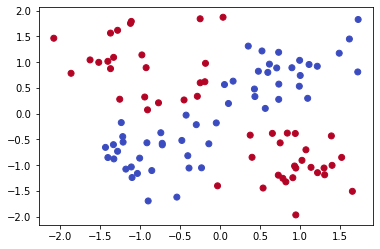

In [30]:
network.reset()
valid_split = 0.2
test_split = 0.1

learn(network, X, Y, valid_split, test_split, writer, epochs=200, lrate=1.5)

In [38]:
%tensorboard --logdir logs --port 6007

Reusing TensorBoard on port 6007 (pid 16188), started 6 days, 1:01:52 ago. (Use '!kill 16188' to kill it.)